# Combined model of RV and H$\alpha$

## Overall model is quasiperiodic in RV, quasiperiodic + extra squared exponential in H$\alpha$

<ul>
    <li>When doing a GP model of H$\alpha$ alone, I found that adding a long-term signal drift using an extra squared exponential kernel improved the fit. This may make sense because there could be a long-term activity cycle that is only partially covered by this dataset.</li>
    <li>I didn't find the extra signal drift as important for the RV data; perhaps the long-term cycle manifests less in RV than in H$\alpha$?</li>
    <li>Period and decorrelation time are shared between two quasi-periodic kernels; amplitude and roughness can be different.</li>
</ul>

### 1. Get data:

In [2]:
import numpy as np
from astropy.stats import LombScargle
import matplotlib.pyplot as plt
%matplotlib inline
# Read the data
date, rv, rverr, ha, haerr, nad, naderr, fwhm, fwhmerr, bis, biserr = \
    np.loadtxt("../data/dbf_HARPS.txt", unpack=True, \
    usecols=[1,2,3,4,5,6,7,8,9,10,11], skiprows=21)
dateH, rvH, rverrH, haH, haerrH = \
    np.loadtxt("../data/dbf_HIRES.txt", unpack=True, \
    usecols=[1,2,3,4,5])
first = date[0]
date -= first
dateH -= first
# Put together the HIRES and HARPS measurements of RV and Halpha
alldates = np.concatenate((date, dateH))
allRV = np.concatenate((rv, rvH))
allRVerr = np.concatenate((rverr, rverrH))
allha = np.concatenate((ha, haH))
allhaerr = np.concatenate((haerr, haerrH))
sub = np.argsort(alldates)
alldates = alldates[sub]
allRV = allRV[sub]
allRVerr = allRVerr[sub]
allha = allha[sub]
allhaerr = allhaerr[sub]
# Compute the periodograms
xiR, powR = LombScargle(alldates, allRV, allRVerr).autopower()
xiH, powH = LombScargle(alldates, allha, allhaerr).autopower()

### 2. Plot RV, H$\alpha$, and their periodograms:

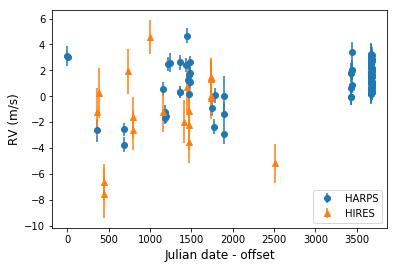

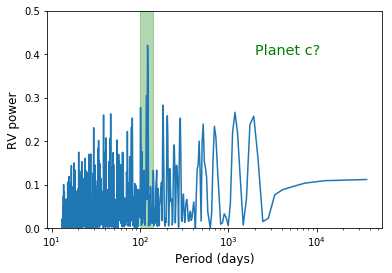

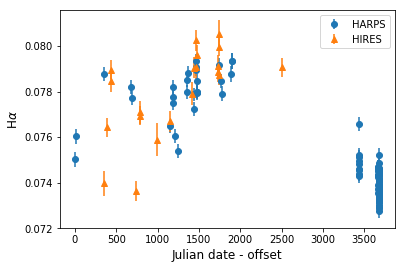

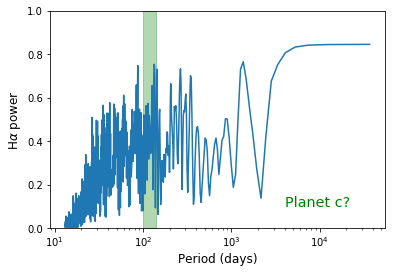

In [3]:
# Plot RV and periodogram
xpts = [101, 106, 111, 116, 121, 126, 131, 136, 141]
ypts = np.ones(9)
plt.figure()
plt.errorbar(date, rv, yerr=rverr, fmt='o', label="HARPS")
plt.errorbar(dateH, rvH, yerr=rverrH, fmt='^', label="HIRES")
plt.legend(loc="lower right")
plt.ylabel("RV (m/s)", fontsize='large')
plt.xlabel("Julian date - offset", fontsize="large")
plt.figure()
plt.plot(1./xiR, powR)
plt.fill_between(xpts, ypts, color="g", alpha=0.3)
plt.ylim([0,0.5])
plt.ylabel("RV power", fontsize="large")
plt.xlabel("Period (days)", fontsize="large")
plt.text(2000,0.4,"Planet c?", color="g", fontsize="x-large")
plt.xscale("log")
plt.figure()
plt.errorbar(date, ha, yerr=haerr, fmt='o', label="HARPS")
plt.errorbar(dateH, haH, yerr=haerrH, fmt='^', label="HIRES")
plt.legend(loc="upper right")
plt.ylabel(r"H$\alpha$", fontsize='large')
plt.xlabel("Julian date - offset", fontsize="large")
plt.figure()
plt.plot(1./xiH, powH)
plt.fill_between(xpts, ypts, color="g", alpha=0.3)
plt.ylim([0,1.])
plt.ylabel(r"H$\alpha$ power", fontsize="large")
plt.xlabel("Period (days)", fontsize="large")
plt.text(4000,0.1,"Planet c?", color="g", fontsize="x-large")
plt.xscale("log")

### 3. Set up the Gaussian processes with shared period and decorrelation time; find best-fit parameters:

In [13]:
# To install george: $ conda install -c conda-forge george
# Most of this code is borrowed from a tutorial in the george documentation:
# https://george.readthedocs.io/en/latest/tutorials/hyper/
from george import kernels
from george import GP
from george import modeling
from scipy.optimize import minimize
from scipy.optimize import Bounds

'''Initial guesses for the hyperparameters that give reasonable
converged values--DO NOT DELETE'''
# Quasi-periodic kernels
constant_guess_RV = 8. # Amplitudes of squared-exponential decorrelation kernels
constant_guess_ha = 4.0e-5
gamma_guess_RV = 3. # Amplitudes of periodic part of kernels
gamma_guess_ha = 12.
metric_guess = 50000. # Decorrelation timescale SQUARED (days)
period_guess = 121. # Best-fit period from GP model of RV alone
# Long-term squared exponential kernel for signal drift in Halpha
lt_constant_ha = 0.0003
lt_metric_ha = 1500000.

'''Can experiment with the hyperparameter initial guesses here'''
# period_guess = 100.
# constant_guess_RV = 9.
metric_guess = 30000.
# lt_constant_ha = 0.0002

# Create the kernels
kexp2_RV = constant_guess_RV * kernels.ExpSquaredKernel(metric=metric_guess)
kexp2_ha = constant_guess_ha * kernels.ExpSquaredKernel(metric=metric_guess)
kper_RV = kernels.ExpSine2Kernel(gamma=gamma_guess_RV, log_period=np.log(period_guess))
kper_ha = kernels.ExpSine2Kernel(gamma=gamma_guess_ha, log_period=np.log(period_guess))
krot_RV = kexp2_RV * kper_RV
krot_ha = kexp2_ha * kper_ha

kexp_lt_ha = lt_constant_ha * kernels.ExpSquaredKernel(metric=lt_metric_ha)
kha = krot_ha + kexp_lt_ha

# Trivial functions that return the LN white noise VARIANCE.
# Note: I'm not 100% sure I'm treating the measurement uncertainties correctly.
def whitenoise_RV(time):
    return np.log(allRVerr**2)

def whitenoise_ha(time):
    return np.log(allhaerr**2)

# Initialize the Gaussian processes 
gp_RV = GP(krot_RV, fit_kernel=True, mean=np.mean(allRV))
        #white_noise=modeling.CallableModel(whitenoise_RV, gradient=None))
gp_ha = GP(kha, fit_kernel=True, mean=np.mean(allha))
        #white_noise=modeling.CallableModel(whitenoise_ha, gradient=None))

# Function that takes concatenated vector containing BOTH sets of GP
# parameters and separates it into two, one for each GP
def split_par_vec(par_vec):
    period = par_vec[0]
    metric = par_vec[1]
    RV_amp = par_vec[2]
    RV_gamma = par_vec[3]
    ha_amp = par_vec[4]
    ha_gamma = par_vec[5]
    lt_ha_amp = par_vec[6]
    lt_ha_metric = par_vec[7]
    RV_pars = [RV_amp, metric, RV_gamma, period]
    ha_pars = [ha_amp, metric, ha_gamma, period, lt_ha_amp, lt_ha_metric]
    return RV_pars, ha_pars

# Function that takes the two parameter vectors and turns them
# into one master parameter vector; also sanity checks that the
# periods and metrics are the same for the quasiperiodic kernels
def make_par_vec(RVpars, hapars):
    RV_amp = RVpars[0]
    RV_metric = RVpars[1]
    RV_gamma = RVpars[2]
    RV_period = RVpars[3]
    ha_amp = hapars[0]
    ha_metric = hapars[1]
    ha_gamma = hapars[2]
    ha_period = hapars[3]
    lt_ha_amp = hapars[4]
    lt_ha_metric = hapars[5]
    assert RV_period == ha_period, "Error: RV and Halpha should have same period"
    assert RV_metric == ha_metric, "Error: RV and Halpha should have same decorrelation timescale"
    master_pars = [RV_period, RV_metric, RV_amp, RV_gamma, \
                   ha_amp, ha_gamma, lt_ha_amp, lt_ha_metric]
    return master_pars

# Set reasonable boundaries for each hyperparameter
# Bounds order is same as parameter order: period, metric, 
# RV exp2 amplitude, RV gamma, ha exp2 amplitude, ha gamma,
# ha long-term amplitude, ha long-term metric
lower_bounds = [-2., 0., -4., 1.0e-5, -20., 1.0e-5, -20., 0.]
upper_bounds = [10., 18., 6., 100., 0., 1000., 0., 23.]

# Create a Bounds object that will restrict minimize to values within
# the boundaries
par_bounds = Bounds(lower_bounds, upper_bounds)

# Define the objective function that will be used to evaluate the goodness
# of the fitted hyperparameters (negative log-likelihood in this case)
def nll(gpPars):
    p_RV, p_ha = split_par_vec(gpPars)
    gp_RV.set_parameter_vector(p_RV)
    gp_ha.set_parameter_vector(p_ha)
    ll_RV = gp_RV.log_likelihood(allRV, quiet=True)
    ll_ha = gp_ha.log_likelihood(allha, quiet=True)
    ll = ll_RV + ll_ha
    return -ll if np.isfinite(ll) else 1e25

# You need to compute both GPs before starting the optimization.
gp_RV.compute(alldates,allRVerr)
gp_ha.compute(alldates,allhaerr)

# Combine the parameter vectors for both Gaussian processes into
# one (objective function sent to minimize must have only one
# input vector)
RV_pars = gp_RV.get_parameter_vector()
ha_pars = gp_ha.get_parameter_vector()
allpars = make_par_vec(RV_pars, ha_pars)
print("Master parameter vector:", allpars)

# Print the initial ln-likelihood
print("Initial ln-likelihood:", -nll(allpars))

# Run the optimization routine. I DON'T THINK USING george's 
# GRAD_LOG_LIKELIHOOD FUNCTION WILL WORK HERE BECAUSE PERIOD AND 
# DECORRELATION TIMESCALE WILL HAVE DIFFERENT GRADIENTS IN THE 
# HALPHA AND RV PARAMETER SETS.
# results = minimize(nll, allpars, jac=grad_nll, method="L-BFGS-B")
results = minimize(nll, allpars, method="TNC", bounds=par_bounds, \
                   options={'maxiter':3000, 'ftol':1.0e-8, 'xtol':1.0e-9, \
                           'gtol':1.0e-8})

# Update the kernels, print the final log-likelihood and results
results_RV, results_ha = split_par_vec(results.x)
final_loglike = -nll(results.x)
npts = len(alldates)
npars = len(allpars)
bic = np.log(npts) * npars - 2.*final_loglike
print("Final ln-likelihood:", final_loglike)
print(results)
gp_RV.set_parameter_vector(results_RV)
gp_ha.set_parameter_vector(results_ha)
print("\nBayesian information criterion: %4.2f" % bic)

Master parameter vector: [4.700480365792417, 10.308952660644293, 2.0794415416798357, 3.0, -10.126631103850338, 12.0, -8.111728083308073, 14.22097566607244]
Initial ln-likelihood: 407.96623648495506
Final ln-likelihood: 412.39321829180153
     fun: -412.39321829180153
     jac: array([-2.00167733e+01, -1.11762120e+00, -1.27897692e-02,  5.62238256e-02,
        9.47626404e+00, -1.85605131e-01,  1.86904572e+00, -1.38544465e+00])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 158
     nit: 22
  status: 1
 success: True
       x: array([  4.62860897,  10.37018284,   1.94826677,   2.90457798,
       -10.39578689,   5.39121609,  -8.22828129,  14.24362988])

Bayesian information criterion: -787.04


#### Human-readable parameters:

In [14]:
print("Period: %4.2f days" % np.exp(results.x[0]), '\n')
print("Metric: %8.2f days squared" % np.exp(results.x[1]))
print("Decorrelation timescale (sqrt of metric): % 8.2f days" % np.sqrt(np.exp(results.x[1])), '\n')
print("Constant RV kernel multiplier: % 3.2f" % np.exp(results.x[2]))
print("Sqrt of constant RV kernel multiplier (physically meaningful): % 3.2f" % np.sqrt(np.exp(results.x[2])), '\n')
print("Gamma (multiplier of sin2) for RV: % 3.2f" % results.x[3])
print("Roughness parameter omega for RV: % 3.2f" % np.sqrt(0.5/results.x[3]), '\n')
print("Constant Halpha quasiperiodic kernel multiplier: % 0.7f" % np.exp(results.x[4]))
print("Sqrt of constant Halpha quasiperiodic kernel multiplier (physically meaningful): %0.7f" % np.sqrt(np.exp(results.x[4])), '\n')
print("Gamma (multiplier of sin2) for Halpha: % 3.3f" % results.x[5])
print("Roughness parameter omega for Halpha: % 3.3f" % np.sqrt(0.5/results.x[5]), '\n')
print("Constant Halpha long-term drift kernel multiplier: %0.6f" % np.exp(results.x[6]))
print("Sqrt of constant Halpha long-term drift kernel multiplier (physically meaningful): %0.6f" % np.sqrt(np.exp(results.x[6])), '\n')
print("Long-term drift metric: %8.2f days squared" % np.exp(results.x[7]))
print("Long-term drift timescale (sqrt of metric): %8.2f days" % np.sqrt(np.exp(results.x[7])))

Period: 102.37 days 

Metric: 31894.31 days squared
Decorrelation timescale (sqrt of metric):   178.59 days 

Constant RV kernel multiplier:  7.02
Sqrt of constant RV kernel multiplier (physically meaningful):  2.65 

Gamma (multiplier of sin2) for RV:  2.90
Roughness parameter omega for RV:  0.41 

Constant Halpha quasiperiodic kernel multiplier:  0.0000306
Sqrt of constant Halpha quasiperiodic kernel multiplier (physically meaningful): 0.0055282 

Gamma (multiplier of sin2) for Halpha:  5.391
Roughness parameter omega for Halpha:  0.305 

Constant Halpha long-term drift kernel multiplier: 0.000267
Sqrt of constant Halpha long-term drift kernel multiplier (physically meaningful): 0.016340 

Long-term drift metric: 1534369.16 days squared
Long-term drift timescale (sqrt of metric):  1238.70 days


### 4. Use <a href="http://dfm.io/emcee/current/"><tt>emcee</tt></a> to sample the Gaussian processes:
<ol>
<li>Visualize radial velocity and H$\alpha$ curves that are consistent with our rotation model, and</li>
<li>Find the uncertainties on our model parameters.</li>
</ol>

In [6]:
import emcee
emcee.__version__

'3.0rc2'

In [16]:
import emcee

# The same boundaries used in minimize will define the edges of uniform
# prior windows
def lnprior(pars):
    for i in range(len(pars)):
        if ((pars[i] < lower_bounds[i]) or (pars[i] > upper_bounds[i])):
            return -np.inf
    return 0.

# The full log-probability function, including priors
def lnprob(pars):
    ll = -nll(pars)
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ll

# Run the Gaussian processes again
gp_RV.compute(alldates)
gp_ha.compute(alldates)
print("Computed the Gaussian processes")

# Set up the sampler.
nwalkers, ndim = 50, len(allpars)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
pstart = results.x
p0 = pstart + 1.0e-4 * np.random.randn(nwalkers, ndim)
# Use smaller starting distribution in parameter space for tiny numbers: 
# constants multiplying the Halpha exp2 kernels
p0[:,4] = pstart[4] + 3.0e-7 * np.random.randn(nwalkers)
p0[:,6] = pstart[6] + 3.0e-7 * np.random.randn(nwalkers)

print("Running burn-in")
nburn = 200
p0, _, _ = sampler.run_mcmc(p0, nburn,, progress=True)

nproduce = 1200
p1, _, _ =sampler.run_mcmc(p0, nproduce, progress=True)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Computed the Gaussian processes
Running burn-in


100%|██████████| 1200/1200 [01:40<00:00, 11.65it/s]

Mean acceptance fraction: 0.083


### Run more steps:

In [7]:
nproduce = 4000
p2, _, _ = sampler.run_mcmc(p1, nproduce)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.235


In [50]:
nproduce = 6000
p3, _, _ = sampler.run_mcmc(p2, nproduce)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.277


In [60]:
nproduce = 20000
p4, _, _ = sampler.run_mcmc(p3, nproduce, progress=True)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

100%|██████████| 20000/20000 [31:45<00:00,  9.37it/s] 

Mean acceptance fraction: 0.299


### 4.1 Examine MCMC convergence

<img src="attachment:image.png" width="600">

As [Brooks and Gelman (1997)](https://faculty.washington.edu/jmiyamot/p548/brookssp%20general%20methods%20f%20monitoring%20convergence%20o%20iterative%20sims.pdf) have suggested, if $R_c<1.2$ for all model parameters, one can be fairly confident that convergence has been reached. Otherwise, longer chains or other means for improving the convergence may be needed. Even more reassuring is to apply the more stringent condition $R_c<1.1$, which is the criterion I use in the examples below.

In [20]:
def gelman_rubin(chain):
    
    def rscore(x, num_samples):
        # Calculate between-chain variance
        B = num_samples * np.var(np.mean(x, axis=1), axis=0, ddof=1)

        # Calculate within-chain variance
        W = np.mean(np.var(x, axis=1, ddof=1), axis=0)

        # Estimate of marginal posterior variance
        Vhat = W * (num_samples - 1) / num_samples + B / num_samples

        return np.sqrt(Vhat / W)
    
    Rhat = {}
    varnumber = chain.shape[2]
    
    for var in range(varnumber):
        x = chain[:,:,var]
        numsaples = x.shape[1]
        Rhat[str(var)] = rscore(x,numsaples)
    
    return Rhat

#I'm not 100% sure that this function works correctly.

In [21]:
print("Gelmen-Rubin Diagnostic:")
gelman_rubin(sampler.chain[:,200:,:])

Gelmen-Rubin Diagnostic:


{'0': 1.0000950175257657,
 '1': 1.0000444828386532,
 '2': 1.0157021834163618,
 '3': 1.0080899605344518,
 '4': 1.0183387082805064,
 '5': 1.0229852658184093,
 '6': 1.0200092635892513,
 '7': 1.0176080423287373}

[Brooks, S. P., and A. Gelman. 1997. General Methods for Monitoring Convergence of Iterative Simulations. Journal of Computational and Graphical Statistics 7: 434–455.](https://faculty.washington.edu/jmiyamot/p548/brookssp%20general%20methods%20f%20monitoring%20convergence%20o%20iterative%20sims.pdf)

In [94]:
#W = np.sum(sampler.chain[:,nburn:,0].std(axis=1)**2) / nwalkers
num_samples = sampler.chain[:,nburn:,:].shape[1]

# Calculate within-chain variance
W = sampler.chain[:,nburn:,0].var(axis=1,ddof=1).mean()
# Calculate between-chain variance
B = num_samples * sampler.chain[:,nburn:,0].mean(axis=1).var(axis=0,ddof=1)
# Estimate of marginal posterior variance
Vhat = W * (num_samples - 1) / num_samples + B / num_samples

Rhat = np.sqrt(Vhat / W)
print("Gelmen-Rubin Diagnostic: {}".format(Rhat))

Gelmen-Rubin Diagnostic: 1.3724059201443495


### 4.2 Monitoring progress
Follow https://emcee.readthedocs.io/en/latest/tutorials/monitor/

In [101]:
# Set up the backend
filename = 'GP_MCMC.h5'  #Use GP_MCMC.h5 to save the progress
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, backend=backend)

In [107]:
from multiprocessing import Pool  # make use of multiple CPUs to speed up slow sampling

In [111]:
max_n = 400000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
with Pool() as pool: # make use of multiple CPUs to speed up slow sampling
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, backend=backend, pool = pool)
    for sample in sampler.sample(p0, iterations=max_n, progress=True):  # sampler.sample is the same with sampler.run_mcmc
        # Only check convergence every 100 steps
        if sampler.iteration % 100:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau

 72%|███████▏  | 289382/400000 [9:01:49<3:27:06,  8.90it/s]  Process ForkPoolWorker-20:
Process ForkPoolWorker-24:
Process ForkPoolWorker-23:
Process ForkPoolWorker-19:
Process ForkPoolWorker-17:
Process ForkPoolWorker-21:
Process ForkPoolWorker-22:
Process ForkPoolWorker-18:



KeyboardInterrupt: 

I interrupted the sampling since it took too much time.

In [112]:
sampler.iteration

291800

In [113]:
tau # autocorrelation time for each parameter

array([4292.58537224, 5043.89792413,  257.67877907, 1719.68913214,
        665.67715704, 1503.59098682,  266.73077595,  575.35124115])

In [114]:
converged

False

Sampler interation steps are not more than 100$\tau$ for the first two parameters.

### 4.3 Autocorrelation analysis & convergence
Follow https://emcee.readthedocs.io/en/latest/tutorials/autocorr/

#### In the case of MCMC, the samples are not independent and the error is actually given by

$$
\sigma^2 = \frac{\tau_f}{N}\,\mathrm{Var}_{p(\theta)}[f(\theta)]
$$

where $\tau_f$ is the **integrated autocorrelation time** for the chain $f(\theta^{(n)})$.
In other words, $N/\tau_f$ is the effective number of samples and <u> $\tau_f$ is the number of steps that are needed before the chain "forgets" where it started.</u>
This means that, if you can estimate $\tau_f$, then you can estimate the number of samples that you need to generate to reduce the relative error on your target integral to (say) a few percent.

---

We estimate $\tau_f$ as

$$
\hat{\tau}_f (M) = 1 + 2\,\sum_{\tau=1}^M \hat{\rho}_f(\tau)
$$

for some $M \ll N$.
As discussed by [Sokal in the notes](https://pdfs.semanticscholar.org/0bfe/9e3db30605fe2d4d26e1a288a5e2997e7225.pdf), the introduction of $M$ decreases the variance of the estimator at the cost of some added bias and he suggests choosing the smallest value of $M$ where $M \ge C\,\hat{\tau}_f (M)$ for a constant $C \sim 5$.
Sokal says that he finds this procedure to work well for chains longer than $1000\,\tau_f$, but the situation is a bit better with emcee because we can use the parallel chains to reduce the variance and we've found that <u>chains longer than about $50\,\tau$ are often sufficient.</u>


#### Now let’s take a look at how the autocorrelation time estimate (averaged across dimensions) changed over the course of this run. In this plot, the τ estimate is plotted (in blue) as a function of chain length and, for comparison, the N>100τ threshold is plotted as a dashed line.

In [14]:
n = 100*np.arange(1, index+1)
y = autocorr[:index]
plt.plot(n, n / 100.0, "--k")
plt.plot(n, n / 50.0, "-.k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1*(y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");
#plt.xscale('log')

NameError: name 'autocorr' is not defined

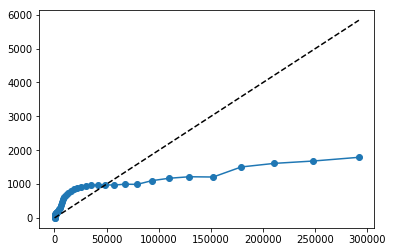

In [108]:
N = np.exp(np.linspace(np.log(100), np.log(sampler.chain.shape[1]), 50)).astype(int)
tau_new = np.empty(len(N))

for i, n in enumerate(N):
    tau_new[i]= np.mean(emcee.autocorr.integrated_time(sampler.get_chain()[:n,:,:], tol=0))

plt.plot(N,tau_new,"o-", label="new")    
plt.plot(N, N/50., '--k', label=r'$\tau = N/100$') 
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.xlim(0, N.max())
plt.ylim(0, tau_new.max() + 0.1*(tau_new.max() - tau_new.min()))
plt.legend()

In [22]:
plt.plot(N,tau_new,"o-", label="new")    
plt.plot(N, N/50., '--k', label=r'$\tau = N/50$') 
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.xlim(0, N.max())
plt.ylim(0, tau_new.max() + 0.1*(tau_new.max() - tau_new.min()))
plt.legend()

NameError: name 'N' is not defined

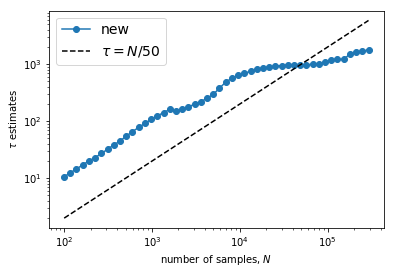

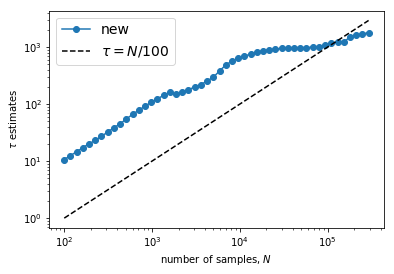

In [115]:
plt.loglog(N,tau_new,"o-", label="new")    
plt.loglog(N, N/50., '--k', label=r'$\tau = N/50$') 
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

plt.figure()
plt.loglog(N,tau_new,"o-", label="new")    
plt.loglog(N, N/100., '--k', label=r'$\tau = N/100$') 
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

For comparison, we have also plotted the $\tau = N/100$ line to show that, once the estimate crosses that line, The estimates are starting to get more reasonable.
This suggests that you probably shouldn't trust any estimate of $\tau$ unless you have more than $F\times\tau$ samples for some $F \ge 50$.
Larger values of $F$ will be more conservative, but they will also (obviously) require longer chains.

In [29]:
tau = sampler.get_autocorr_time()
tau

array([4293.14487129, 5044.50847416,  257.58368279, 1719.35253751,
        665.51600969, 1502.95000984,  266.72570186,  575.17686453])

burn-in: 200
thin: 100
flat chain shape: (600, 8)
flat log prob shape: (600,)


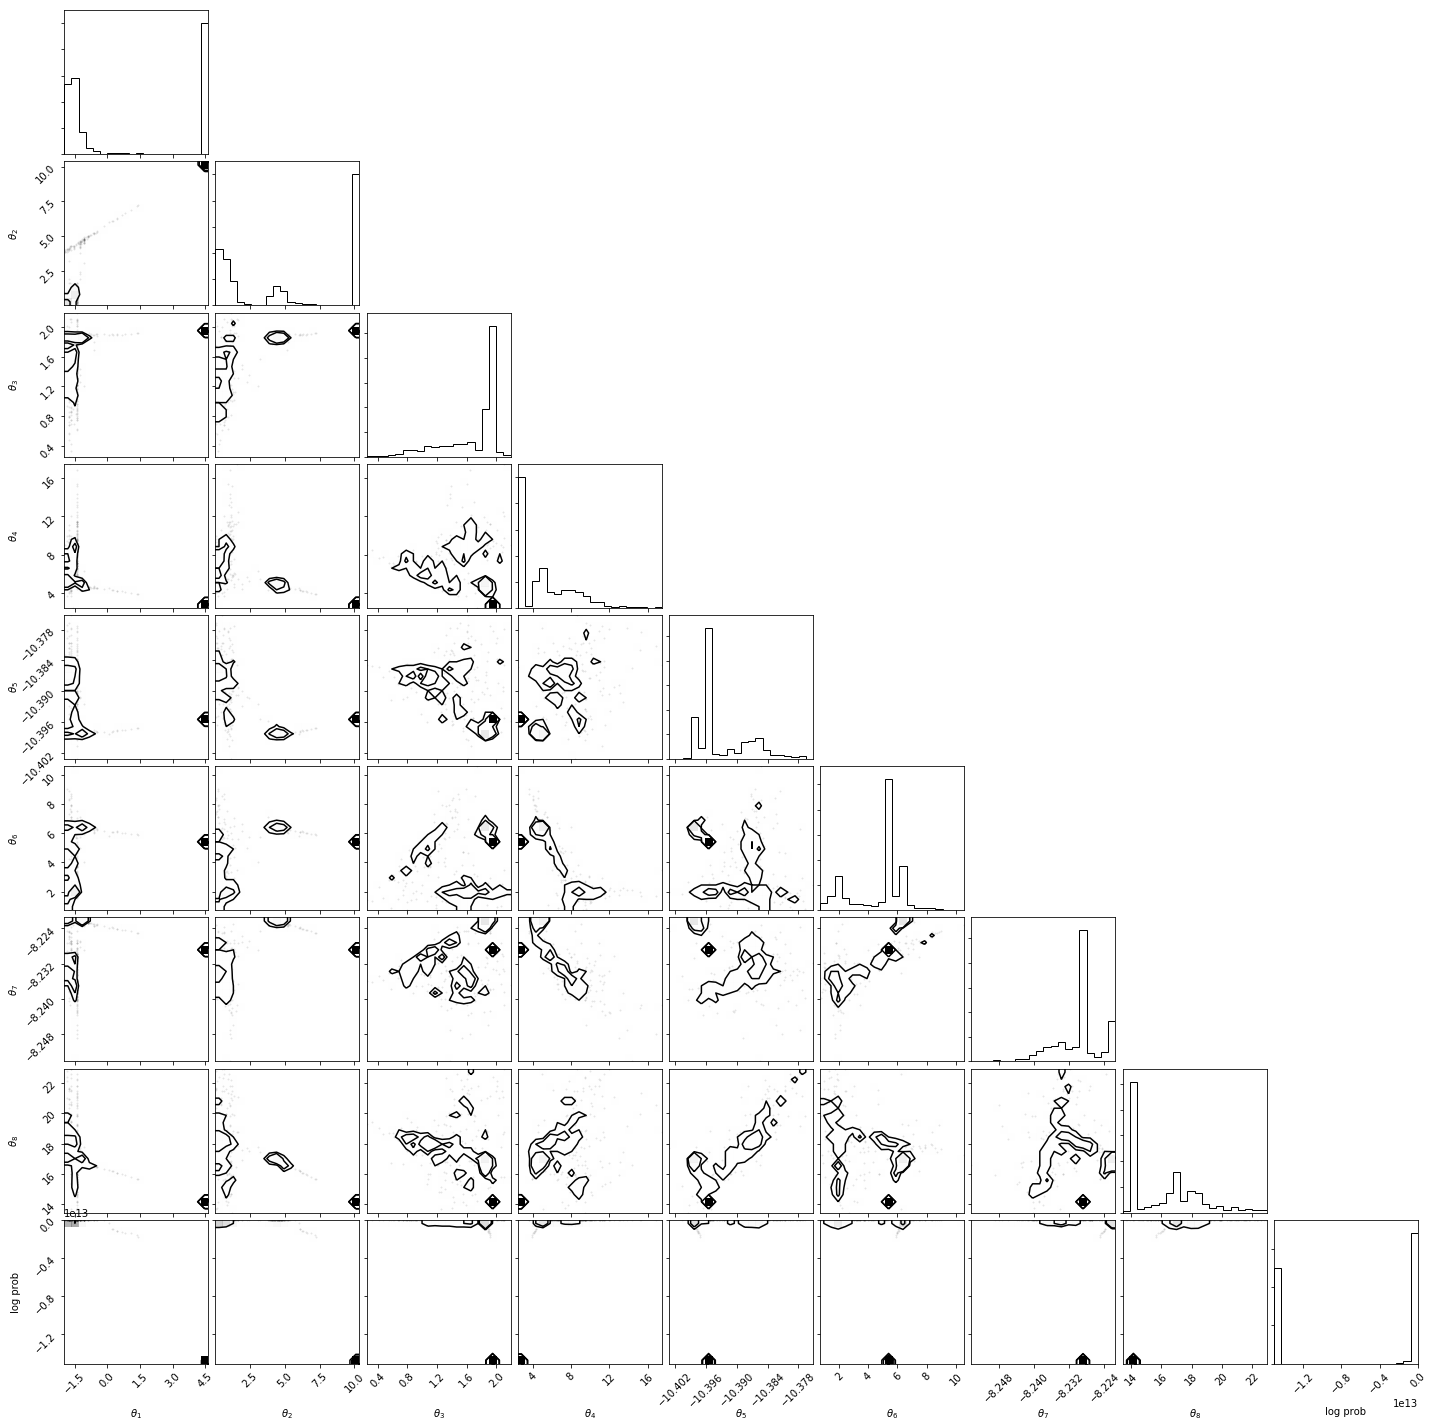

In [25]:
#tau = sampler.get_autocorr_time()
#burnin = int(2*np.max(tau))
#thin = int(0.5*np.min(tau))
burnin = 200
thin = 100
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
#print("flat log prior shape: {0}".format(log_prior_samples.shape))

all_samples = np.concatenate((
    samples, log_prob_samples[:, None]), axis=1)

labels = list(map(r"$\theta_{{{0}}}$".format, range(1, ndim+1)))
labels += ["log prob"]
import corner
corner.corner(all_samples, labels=labels);

## Open the saved file
In some cases I shut down the kernel, but I can recover my sampling data from the saved file.

In [6]:
filename = 'GP_MCMC.h5'
reader = emcee.backends.HDFBackend(filename)
reader.iteration

291800

In [7]:
tau = reader.get_autocorr_time()
burnin = int(2*np.max(tau))
thin = int(0.5*np.min(tau))
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))

burn-in: 10089
thin: 128
flat chain shape: (110000, 8)
flat log prob shape: (110000,)


In [8]:
nwalkers, ndim = 50, len(allpars)
new_backend = emcee.backends.HDFBackend(filename)
new_sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, backend=new_backend)

In [25]:
new_sampler.chain.shape

(50, 291800, 8)

In [121]:
print("Gelmen-Rubin Diagnostic:")
gelman_rubin(sampler.chain[:,nburn:,:])

Gelmen-Rubin Diagnostic:


{'0': 1.2641983354578257,
 '1': 1.1397986630350965,
 '2': 1.0028272417481143,
 '3': 1.081426762261882,
 '4': 1.0110540927480005,
 '5': 1.0182344000436057,
 '6': 1.000893272566183,
 '7': 1.01765129662244}



### 5. Examine RV and H$\alpha$ time series predicted by the Gaussian processes:

LinAlgError: SVD did not converge

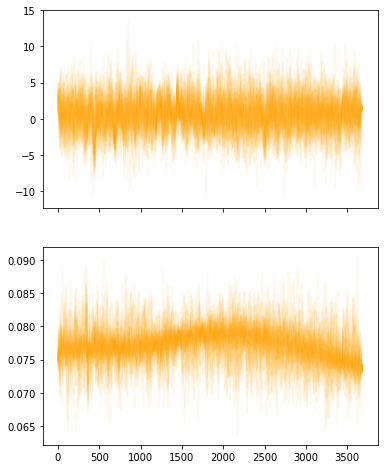

In [9]:
# Make a flat chain of samples with the initial burn-in discarded
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

# Plot 50 possible RV curves drawn from the flat chain, along with the data
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(6,8))
tt = np.linspace(alldates[0], alldates[-1], 501, endpoint=True)
for i in range(50):
    # Choose a sample
    n = np.random.randint(0, samples.shape[0])
    spars_RV, spars_ha = split_par_vec(samples[n])
    gp_RV.set_parameter_vector(spars_RV)
    gp_ha.set_parameter_vector(spars_ha)
    # Plot a single sample.
    ax1.plot(tt, gp_RV.sample_conditional(allRV, tt), "orange", alpha=0.07)
    ax2.plot(tt, gp_ha.sample_conditional(allha, tt), "orange", alpha=0.07)
# Plot the real data
ax1.errorbar(alldates, allRV, yerr=allRVerr, fmt='o')
ax2.errorbar(alldates, allha, yerr=allhaerr, fmt='o')
ax2.set_xlim(alldates[0], alldates[-1])
ax2.set_xlabel("Julian date - offset", fontsize='large')
ax1.set_ylabel("RV (m/s)", fontsize='large')
ax2.set_ylabel(r"H$\alpha$", fontsize='large')

### 6. Examine posteriors and covariances:

In [34]:
print("burn-in: {0}".format(burnin))

burn-in: 10089


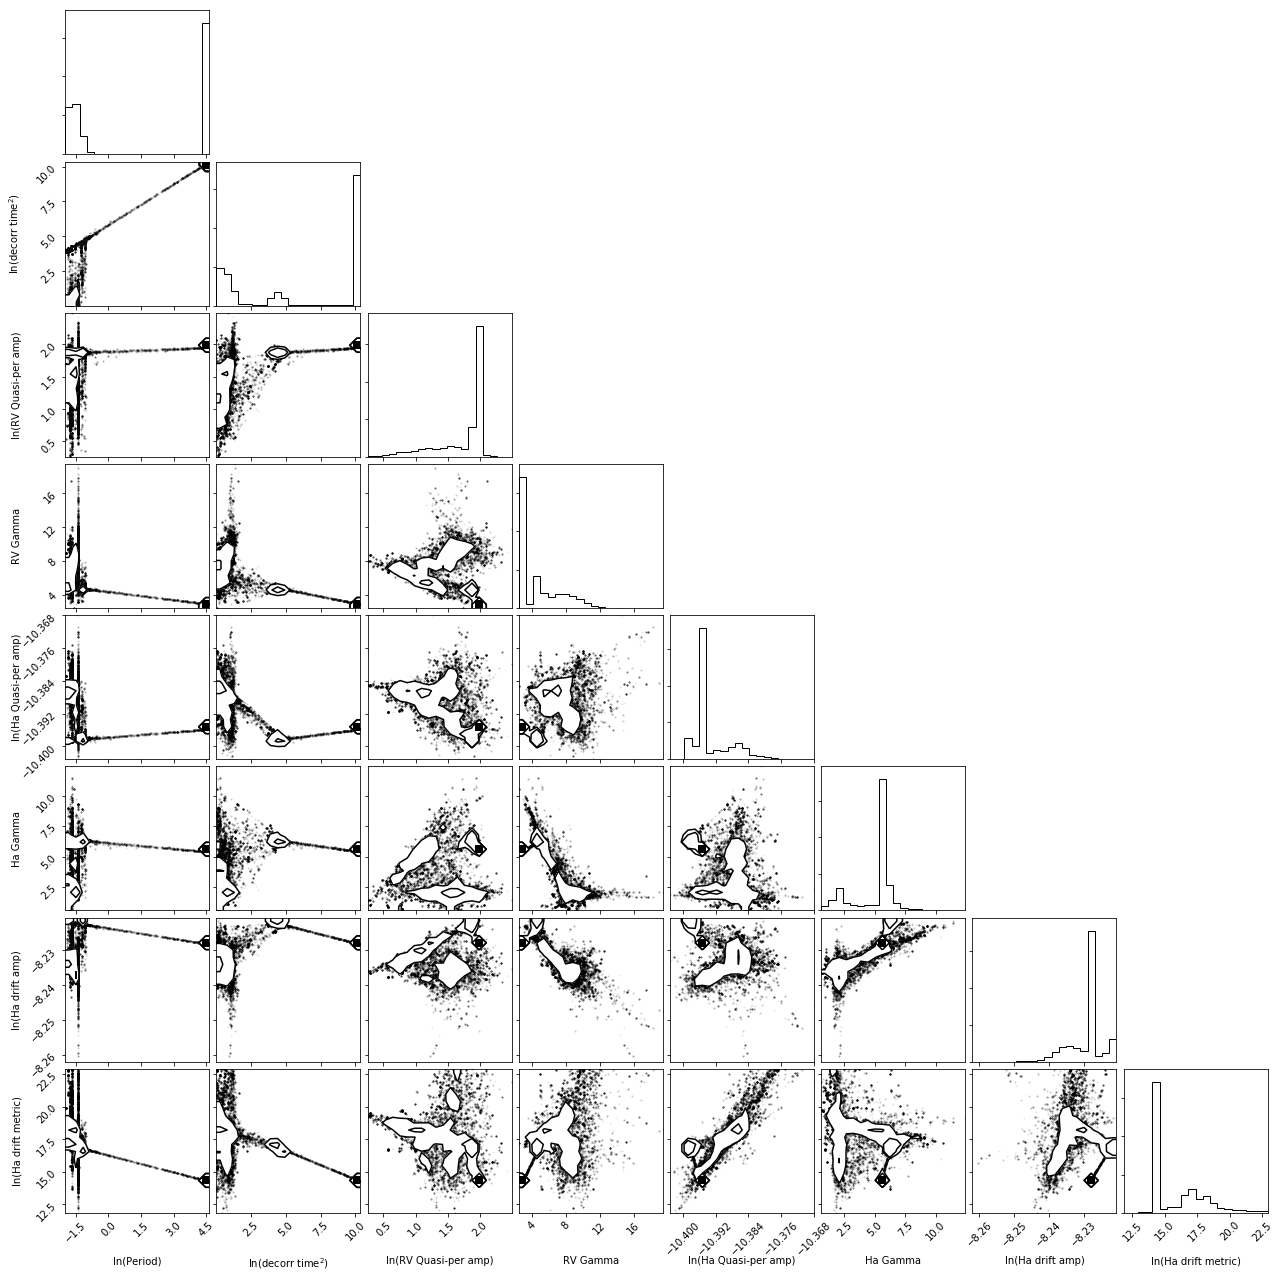

In [26]:
import corner
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
parnames = ["ln(Period)", "ln(decorr time$^2$)", "ln(RV Quasi-per amp)", \
            "RV Gamma", "ln(Ha Quasi-per amp)", "Ha Gamma", "ln(Ha drift amp)", \
            "ln(Ha drift metric)"]
cfig = corner.corner(samples, labels=parnames)

### 7. What are the period and decorrelation timescale?

Bin containing most probable period: 112.8 -- 140.3 days
Bin containing most probable decorrelation time:  1.0 -- 14.8 days
Bin containing 2nd most probable decorrelation time: 14.8 -- 28.7 days

Period: 16, 50, 84 percentiles = 83.47 242.66 5821.99 days
Decorrelation time: 16, 50, 84 percentiles = 1.24 9.53 161.92 days

Period = 242.66 +5579.34 -159.18 days
Decorrelation time = 9.53 +152.39 -8.29 days


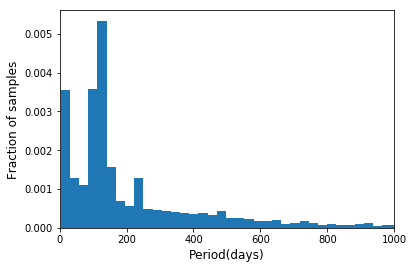

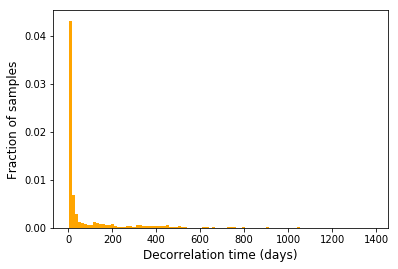

In [12]:
# Plots
plt.figure()
periods = np.exp(samples[:,0])
dctimes = np.exp(0.5*samples[:,1])
n_per, bins_per, _ = plt.hist(periods, 800, density=True)
plt.xlabel("Period(days)", fontsize='large')
plt.ylabel("Fraction of samples", fontsize='large')
plt.xlim([0,1000])
plt.figure()
n_dc, bins_dc, _ = plt.hist(dctimes, 100, density=True, facecolor='orange')
plt.xlabel("Decorrelation time (days)", fontsize='large')
plt.ylabel("Fraction of samples", fontsize='large')

# Numbers
per_bestbin = np.argmax(n_per)
dc_bestbin = np.argmax(n_dc)
dc_sort = np.argsort(n_dc)
print("Bin containing most probable period: %4.1f -- %4.1f days" \
      % (bins_per[per_bestbin], bins_per[per_bestbin+1]))
print("Bin containing most probable decorrelation time: %4.1f -- %4.1f days" \
      % (bins_dc[dc_bestbin], bins_dc[dc_bestbin+1]))
print("Bin containing 2nd most probable decorrelation time: %4.1f -- %4.1f days" \
      % (bins_dc[dc_sort[-2]], bins_dc[dc_sort[-2]+1]))
pctiles = [16, 50, 84]
pervals = np.percentile(periods, pctiles)
dcvals = np.percentile(dctimes, pctiles)
print("\nPeriod: 16, 50, 84 percentiles = %4.2f %4.2f %4.2f" \
      % (pervals[0], pervals[1], pervals[2]), "days")
print("Decorrelation time: 16, 50, 84 percentiles = %4.2f %4.2f %4.2f" \
      % (dcvals[0], dcvals[1], dcvals[2]), "days")

# Amusing myself with python's crazy way of interpreting lists and tuples
# Now I have a fun formatting example for future reference! (adapted from
# emcee tutorial)
po, dco = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),\
              zip(*np.percentile(np.column_stack((periods, dctimes)), \
              pctiles, axis=0)))
print("\nPeriod = %4.2f +%4.2f -%4.2f" % po, "days")
print("Decorrelation time = %4.2f +%4.2f -%4.2f" % dco, "days")

### 8. What path through parameter space does each walker take?

In [ ]:
fig, axarr = plt.subplots(8, sharex=True, figsize=(6,12))
nsteps = sampler.chain.shape[1]
step = range(nsteps)
print(len(step))
for i in range(len(axarr)):
    for w in range(nwalkers):
        axarr[i].plot(step, sampler.chain[w,:,i])
    axarr[i].set_ylabel(parnames[i])
axarr[7].set_xlabel('Step number')

291800


### 9. What is the BIC (Bayesian Information Criterion) distribution?

<par>$BIC = \ln(n) k - 2 \ln(\hat{L})$ where $n$ is the number of data points, $k$ is the number of free hyperparameters, and $\hat{L}$ is the likelihood of the observed dataset given the hyperparameters.</par>

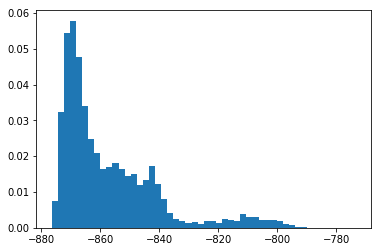

In [22]:

nsamples = nwalkers * nproduce
bics = np.zeros(nsamples)
for i in range(nsamples):
    bics[i] = np.log(npts) * npars + 2.*nll(samples[i,:])
n_bics, bins_bics, _ = plt.hist(bics, 50, density=True)

## These models are still pretty rough! I am consulting with a "real" statistician about the proper likelihood function for the shared Gaussian process model. We have to think about whether the posteriors make sense.